<a href="https://colab.research.google.com/github/unmtransinfo/CFChemDb/blob/main/notebooks/CFChemDb_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://www.nih-cfde.org/wp-content/uploads/2020/11/CFDE_logo-color-web.png" width="200">

# CFChemDb Demo

* https://www.nih-cfde.org/

In this simple CFDE-IDG demo we pull CFChemDb data from AWS EC2 cloud instance, for display, analysis and integration with related entities and datasets.

In [ ]:
import sys,os,json,requests,urllib.request
import pandas as pd
!pip install psycopg2-binary
import psycopg2,psycopg2.extras
from IPython.display import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Database credentials

In [ ]:
dsn = (f"host='unmtid-dbs.net' port='5442' dbname='cfchemdb' user='commoner' password='easement'")
dbcon = psycopg2.connect(dsn)
dbcon.cursor_factory = psycopg2.extras.DictCursor

### Tables and row-counts

In [ ]:
tables = pd.read_sql(f"SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'", dbcon)
rowcounts=None;
for tname in tables.table_name:
  df_this = pd.read_sql(f"SELECT COUNT(*) AS rowcount FROM {tname}", dbcon)
  df_this["table"] = tname
  rowcounts = df_this if rowcounts is None else pd.concat([rowcounts, df_this])
rowcounts = rowcounts[["table", "rowcount"]]
rowcounts

,table,rowcount
0,drugcentral,4713
0,glygen,33531
0,idg,251677
0,lincs,32469
0,meta,1
0,mols,311041
0,properties,311041
0,refmet,154676
0,reprotox,965


### Columns

In [ ]:
columns=None;
for tname in tables.table_name:
  sql2 = (f"SELECT column_name,data_type FROM information_schema.columns WHERE table_schema = 'public' AND table_name = '{tname}'")
  df_this = pd.read_sql(sql2, dbcon)
  df_this["table"] = tname
  columns = df_this if columns is None else pd.concat([columns, df_this])
columns = columns[["table", "column_name", "data_type"]]
columns

,table,column_name,data_type
0,drugcentral,id,character varying
1,drugcentral,name,character varying
2,drugcentral,cas_reg_no,character varying
3,drugcentral,smiles,character varying
4,drugcentral,inchikey,character varying
...,...,...,...
2,reprotox,pubchem_cid,character varying
3,reprotox,smiles,character varying
4,reprotox,term,character varying
5,reprotox,cansmi,character varying


### Drug from DrugCentral

In [ ]:

drug = pd.read_sql("SELECT * FROM drugcentral dc WHERE name = 'ranitidine'", dbcon)
drug.transpose()

,0
id,2358
name,ranitidine
cas_reg_no,66357-35-5
smiles,CNC(NCCSCC1=CC=C(CN(C)C)O1)=C[N+]([O-])=O
inchikey,VMXUWOKSQNHOCA-UHFFFAOYSA-N
inchi,InChI=1S/C13H22N4O3S/c1-14-13(9-17(18)19)15-6-...
formula,C13H22N4O3S
molweight,314.4
cansmi,CNC(=C[N+](=O)[O-])NCCSCc1ccc(CN(C)C)o1
mol_id,1184


### Depict chemical structure via MOL2IMG from UNM.

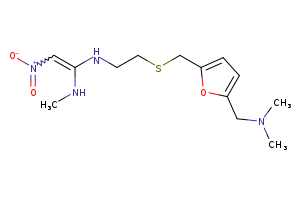

In [ ]:
url = f"https://datascience.unm.edu/tomcat/biocomp/mol2img?smiles={urllib.request.quote(drug['smiles'][0])}"
Image(requests.get(url).content)

### Properties from properties table

In [ ]:
drug_props = pd.read_sql(f"SELECT * FROM properties p WHERE mol_id = {drug['mol_id'][0]}", dbcon)
drug_props.transpose()

,0
mol_id,1184.000
mol_wt,314.411
exact_mol_wt,314.141
heavy_atom_mol_wt,292.235
max_abs_partial_charge,0.464
max_partial_charge,0.274
min_abs_partial_charge,0.274
min_partial_charge,-0.464
num_radical_electrons,0.000
num_valence_electrons,118.000
